# Get data from the Sema dataset

In [14]:
from pymongo import MongoClient
from bson import ObjectId
import pandas as pd

In [15]:
client = MongoClient("mongodb://localhost:27017")

db = client["lifesnaps"]
collection = db["sema"]

doc = collection.find_one({'data':"place"})
print(doc)  

None


In [16]:
from datetime import datetime, timedelta
date_to_filter = datetime(2021, 11, 16)
next_day = date_to_filter + timedelta(days=1)
query = {
    "user_id": ObjectId("621e2f9167b776a240011ccb"),
    "data.SURVEY_NAME": 'Context and Mood Survey',
    "data.CREATED_TS": {
        "$gte": date_to_filter,
        "$lt": next_day}
}

In [17]:
docs = collection.find(query,{'user_id':1,'data.SCHEDULED_TS':1,'data.MOOD':1})

for doc in docs:
    print(doc)

In [18]:
query = {
    "user_id": ObjectId("621e2f9167b776a240011ccb"),
    "data.SURVEY_NAME": 'Context and Mood Survey',
}

In [19]:
import pandas as pd

# Data ophalen uit MongoDB (query moet eerder gedefinieerd zijn)
df = pd.DataFrame(list(collection.find(query)))

# 'data'-kolom is al een dict → direct normaliseren
data_expanded = pd.json_normalize(df["data"])

# Combineer met originele ID-kolommen
df = pd.concat([df[["_id", "user_id"]], data_expanded], axis=1)

# Exporteren naar CSV
df.to_csv('semaSurvey.csv', index=False)

# Bekijk de eerste paar rijen
df.head()

,_id,user_id,PARTICIPANT_ID,STUDY_ID,STUDY_NAME,STUDY_VERSION,SURVEY_ID,SURVEY_NAME,TRIGGER,START_END,...,TOTAL_RT,RAND_PROB,PLACE,PLACE_RT,OTHER,OTHER_RT,MOOD,MOOD_RT,STEPS,STEPS_RT
0,62cc7d568e3d174ffc0fbbb9,621e2f9167b776a240011ccb,s801206794,uk96OixJ-,RAIS Consortium Experiment v2.0,5,BjTcu3Lg-,Context and Mood Survey,scheduled,1,...,3942,<no-response>,HOME,2850,<not-shown>,<not-shown>,TIRED,1092,<no-response>,<no-response>
1,62cc7d568e3d174ffc0fbbd1,621e2f9167b776a240011ccb,s801206794,uk96OixJ-,RAIS Consortium Experiment v2.0,5,BjTcu3Lg-,Context and Mood Survey,scheduled,1,...,5275,<no-response>,HOME,1804,<not-shown>,<not-shown>,RESTED/RELAXED,3471,<no-response>,<no-response>
2,62cc7d568e3d174ffc0fbc4f,621e2f9167b776a240011ccb,s801206794,uk96OixJ-,RAIS Consortium Experiment v2.0,5,BjTcu3Lg-,Context and Mood Survey,scheduled,1,...,4157,<no-response>,WORK/SCHOOL,2571,<not-shown>,<not-shown>,TENSE/ANXIOUS,1586,<no-response>,<no-response>
3,62cc7d568e3d174ffc0fbcaa,621e2f9167b776a240011ccb,s801206794,uk96OixJ-,RAIS Consortium Experiment v2.0,5,BjTcu3Lg-,Context and Mood Survey,scheduled,1,...,5270,<no-response>,ENTERTAINMENT,2346,<not-shown>,<not-shown>,HAPPY,2924,<no-response>,<no-response>
4,62cc7d568e3d174ffc0fbd0b,621e2f9167b776a240011ccb,s801206794,uk96OixJ-,RAIS Consortium Experiment v2.0,5,BjTcu3Lg-,Context and Mood Survey,scheduled,1,...,15110,<no-response>,HOME_OFFICE,9997,<not-shown>,<not-shown>,TIRED,5113,<no-response>,<no-response>


# Data selection 
only select moods and give them a score for each day

In [20]:
data = df[['CREATED_TS','MOOD']]
data

mood_map = {
    '<no-response>': None,
    'ALERT': 1,
    'ANGER': -1,
    'FEAR': -1,
    'HAPPY': 1,
    'JOY': 1,
    'NEUTRAL': 0,
    'RESTED/RELAXED': 1,
    'SAD': -1,
    'SADNESS': -1,
    'SURPRISE': 0,
    'TENSE/ANXIOUS': -1,
    'TIRED': -1,
    None: None  # voor echte null-waarden
}

data['mood_score'] = data['MOOD'].map(mood_map)

C:\Users\xande\AppData\Local\Temp\ipykernel_5140\937158425.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mood_score'] = data['MOOD'].map(mood_map)


In [21]:
data["CREATED_TS"] = pd.to_datetime(data["CREATED_TS"])
# Voeg een kolom toe voor de datum (zonder tijd)
data["date"] = data["CREATED_TS"].dt.date


# Groepeer op datum en sommeer de mood scores
daily_scores = data.groupby("date")["mood_score"].sum().reset_index()

daily_scores

C:\Users\xande\AppData\Local\Temp\ipykernel_5140\1979301880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["CREATED_TS"] = pd.to_datetime(data["CREATED_TS"])
C:\Users\xande\AppData\Local\Temp\ipykernel_5140\1979301880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = data["CREATED_TS"].dt.date


,date,mood_score
0,2021-11-15,1.0
1,2021-11-16,-3.0
2,2021-11-17,0.0
3,2021-11-18,-2.0
4,2021-11-19,-2.0
...,...,...
59,2022-01-13,-3.0
60,2022-01-14,-3.0
61,2022-01-15,0.0
62,2022-01-16,-2.0


In [22]:
daily_scores.to_csv("csv/Mood.csv",index=False)

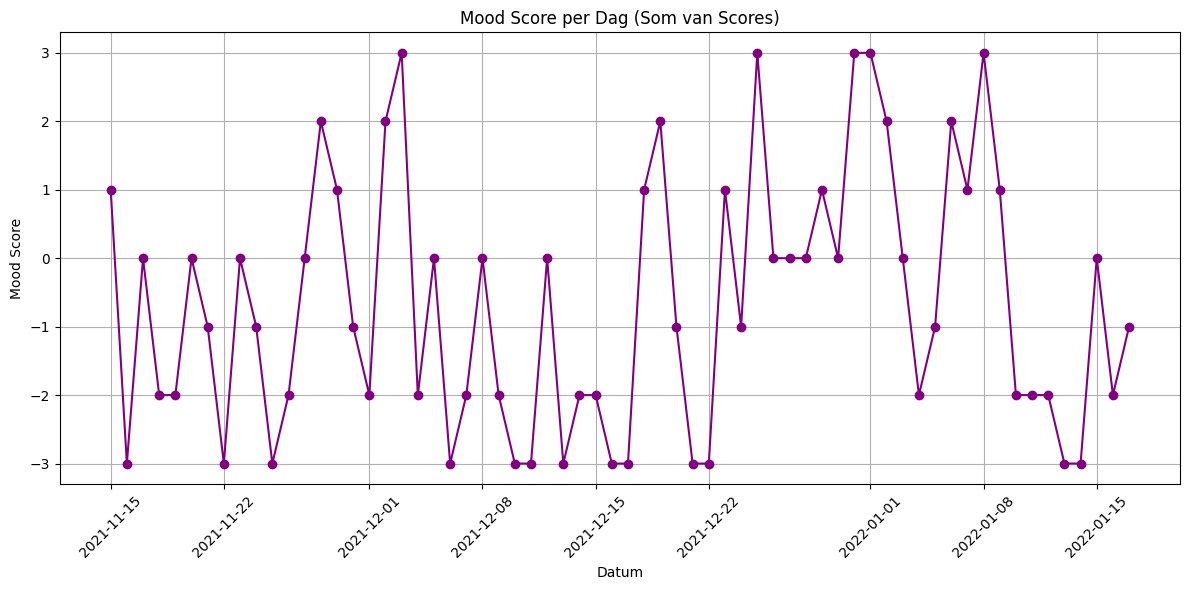

In [11]:
import matplotlib.pyplot as plt

# Zorg dat de datums in goede volgorde staan
daily_scores = daily_scores.sort_values("DATE")

# Plot de som van de MOOD scores per dag
plt.figure(figsize=(12, 6))
plt.plot(daily_scores["DATE"], daily_scores["MOOD_Score"], marker='o', linestyle='-', color='purple')
plt.title("Mood Score per Dag (Som van Scores)")
plt.xlabel("Datum")
plt.ylabel("Mood Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
